## Multi Language Model

### Light Pre-processing

Since the core of the analysis and pre-processing of the data has already been done in the previous notebooks, here we want only to make a few minor checks and some "selection" on the data to use for training.
In particular:
- Check on duplicated titles and null values
- Selection of data based on a threshold per category: we want to keep the data balanced, so it's important to sample the titles with respect to the class with the least data


In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import warnings
import os
import sys
import matplotlib.pyplot as plt
import pathlib
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 500
tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
root_path = str(pathlib.Path(os.path.dirname(os.path.realpath("__file__"))).resolve())
data_path = os.path.join(root_path, "data")

In [4]:
TRAINING_FILE_NAME = "sample_training.csv"
EVAL_FILE_NAME = "sample_evaluation.csv"
LANGS = ["de", "pt", "en", "it"]

In [5]:
df = pd.read_csv(os.path.join(data_path, TRAINING_FILE_NAME))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        600 non-null    object
 1   title     600 non-null    object
 2   category  600 non-null    object
 3   language  600 non-null    object
dtypes: object(4)
memory usage: 18.9+ KB


In [7]:
df.sample(5)

,id,title,category,language
453,de38e5176bfbc22741630ff37b57904f,database administrator con conoscenza di sql,IT,it
213,1675e59a2ca151e00d44f5af04deb5db,safety risk specialist,Finance,en
29,b93d66b332835bc5fd6be0e362daf42e,impiegata impiegato studio paghe,Accounting,it
247,1c347df6d8940eed4095243530d17a9c,teller conroe branch,Finance,en
316,8d3e9e9132865c7a842a18f021d4b6d3,kickstart hilfskoch koch,Food,de


In [8]:
df = df.drop(df[df["title"].isna()].index)

In [9]:
len(df)

600

## Modeling

After a lot of tests and trials and errors, we came up with an encoder to create the embeddings of the titles that has high speed and good accuracy on capturing the context of a sentence/title: [Multilingual Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3), downloadable from tensorflow hub.
The steps that we followed for creating and training our model are:

 1. Splitting data in train/test to evaluate performances and fine-tuning the hyperparameters
 2. Create the model architecture, that in this first phase receives as input the titles already encoded to embeddings:
	 - The structure is composed by few dense layers with the adding of dropout in order to avoid overfitting
	 - Optimizer: *adam*
	 - Loss: SparseCategorical Cross Entropy
3.  Training
4. Evaluation of performances on test data

After we got our fine-tuned model, we are ready to create a self-contained version of it, which is capable of receiving a raw title as input, processing and cleaning it and make the final prediction.
This is done by creating a new version of the model, starting from the previous one, and by adding:
- A new input layer for reading strings
- A pre-processing layer for cleaning the title
- The encoder layer
- The previous model
- A layer to format the final output based on our needs



In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [11]:
label_col = "category"

In [12]:
le = preprocessing.LabelEncoder()
le.fit(df[label_col].values)
df["label"] = le.transform(df[label_col])

In [13]:
df.sample(5)

,id,title,category,language,label
41,bbf91ebbb741cbf48f476f7eeb7416ae,tax identification assignment,Accounting,en,0
8,5e90f1a21bc539885a62102271c5761a,auditor contabile padova,Accounting,it,0
290,8c8d02a3f6841fe9f66b91a132662e19,consultor de hipoteca pessoal,Finance,pt,2
196,da3e8de93e39e205895459d955512fed,primary behavioural teaching assistant wirral,Education,en,1
268,3f0f279bacc48936b46de7e24b4069b4,assicurazioni federali sinistri servizi dallas la dc chicago ny,Finance,it,2


In [14]:
batch_size = 100
title_column = "title"

In [15]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
sentence_encoder = hub.load(model_url)

Metal device set to: Apple M1


2022-04-26 14:44:27.202967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 14:44:27.203096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-26 14:44:29.304703: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-26 14:44:29.305277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
X_ = df[title_column].values
y = df["label"].values

In [17]:
%%time
X = None
for i in tqdm(range(0, len(X_), batch_size)):
    new_encoded = sentence_encoder(X_[i:i+batch_size]).numpy()
    if X is None:
        X = new_encoded
    else:
        X = np.vstack((X, new_encoded))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.49it/s]

CPU times: user 1.09 s, sys: 247 ms, total: 1.33 s
Wall time: 1.11 s


In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

X_train_str, X_val_str, y_train_str, y_val_str = train_test_split(
    X_, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

In [19]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((480, 512), (120, 512), (480,), (120,))

In [20]:
class_names = le.classes_
labels_size = len(le.classes_)
batch_size = 64

In [21]:
def build_model(input_shape, dense_layer_dims, dropout_list, labels_size):
    embeddings_input = tf.keras.Input(
        shape=input_shape,
        dtype=tf.float32,
        name="input_embeddings",
    )
    x = tf.keras.layers.Dense(dense_layer_dims[0], activation="relu", name="dense_1")(
        embeddings_input
    )
    x = tf.keras.layers.Dropout(dropout_list[0], name="dropout_1")(x)
    if len(dense_layer_dims) > 1:
        for i in range(1, len(dense_layer_dims)):
            x = tf.keras.layers.Dense(
                dense_layer_dims[i], activation="relu", name=f"dense_{i+1}"
            )(x)
            x = tf.keras.layers.Dropout(dropout_list[i], name=f"dropout_{i+1}")(x)
    preds = tf.keras.layers.Dense(
        labels_size, activation="softmax", name="dense_final"
    )(x)
    model = tf.keras.Model(embeddings_input, preds, name="model")
    return model

In [22]:
dense_layer_dims = [256, 128, 64]
dropout_list = [0.1, 0.1, 0.1]

In [23]:
model = build_model(
    input_shape=(X_train.shape[1],),
    dense_layer_dims=dense_layer_dims,
    dropout_list=dropout_list,
    labels_size=labels_size,
)

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [25]:
epochs = 5

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="auto", patience=3, verbose=1
        ),
    ],
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/5
1/8 [==>...........................] - ETA: 2s - loss: 1.7934 - sparse_categorical_accuracy: 0.2188

2022-04-26 14:44:30.718550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 28ms/step - loss: 1.7629 - sparse_categorical_accuracy: 0.3583 - val_loss: 1.7006 - val_sparse_categorical_accuracy: 0.5583
Epoch 2/5
8/8 [==============================] - 0s 9ms/step - loss: 1.6059 - sparse_categorical_accuracy: 0.6458 - val_loss: 1.4752 - val_sparse_categorical_accuracy: 0.6750
Epoch 3/5
8/8 [==============================] - 0s 8ms/step - loss: 1.2971 - sparse_categorical_accuracy: 0.7667 - val_loss: 1.0808 - val_sparse_categorical_accuracy: 0.7167
Epoch 4/5
1/8 [==>...........................] - ETA: 0s - loss: 0.9611 - sparse_categorical_accuracy: 0.8594

2022-04-26 14:44:31.008539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 8ms/step - loss: 0.8766 - sparse_categorical_accuracy: 0.8188 - val_loss: 0.6848 - val_sparse_categorical_accuracy: 0.7917
Epoch 5/5
8/8 [==============================] - 0s 8ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.8229 - val_loss: 0.4981 - val_sparse_categorical_accuracy: 0.8000


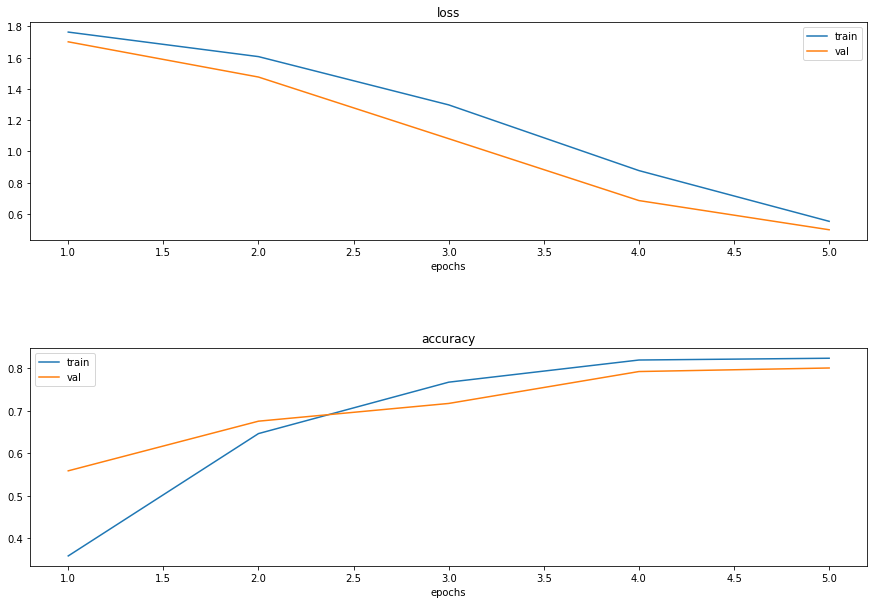

In [27]:
fig = plt.figure(figsize=(15, 10))

epochs = np.arange(1, len(history.history["loss"]) + 1, 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="val")
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, history.history["sparse_categorical_accuracy"], label="train")
plt.plot(epochs, history.history["val_sparse_categorical_accuracy"], label="val")
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend(loc="upper left")

fig.subplots_adjust(hspace=0.5)
# fig.savefig("data/pipeline/neural_network/training_history.png", dpi=300)
plt.show()

In [28]:
n = 100  # for 2 random indices
index_evaluation = np.random.choice(X_val.shape[0], n, replace=False)

In [29]:
# Evaluate the model
loss, acc = model.evaluate(X_val[index_evaluation], y_val[index_evaluation], verbose=2)
print("End to end model on evaluation dataset, accuracy: {:5.2f}%".format(100 * acc))

4/4 - 0s - loss: 0.5130 - sparse_categorical_accuracy: 0.8000 - 56ms/epoch - 14ms/step
End to end model on evaluation dataset, accuracy: 80.00%


In [30]:
sentence_test = sentence_encoder(["expert chef"])

In [31]:
probabilities = model.predict(sentence_test)
class_names[np.argmax(probabilities[0])], np.amax(probabilities)

2022-04-26 14:44:31.704245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


('Food', 0.94068605)

## End-to-end model

In [32]:
with open(os.path.join(data_path, "custom_stopwords.txt")) as f:
    custom_stopwords = [line.rstrip() for line in f.readlines()]

with open(os.path.join(data_path, "to_replace.txt")) as f:
    patterns_to_remove = [line.rstrip() for line in f.readlines()]

In [33]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
    cleaned = tf.strings.lower(input_data)
    cleaned = tf.strings.regex_replace(cleaned, r"\xa0", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\&amp", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"<.*?>", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\(.+?\)", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(patterns_to_remove) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(custom_stopwords) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned, r"[!\"#$%&\'()*+,-.–\/:;<=>?@[\\\]\^_`{|}~]", " ", replace_global=True
    )
    cleaned = tf.strings.regex_replace(cleaned, r"\b\d+\b", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\s+", " ", replace_global=True)
    return tf.strings.strip(cleaned)

In [34]:
custom_standardization(["Expansion Associate - Intern / Part time"]).numpy()[0].decode(
    "utf-8"
)

'expansion associate'

In [35]:
class LabelEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, labels, topn=32, **kwargs):
        self.labels = labels
        self.topn = topn
        super(LabelEncoderLayer, self).__init__(**kwargs)

    def call(self, x):
        batch_size = tf.shape(x)[0]

        tf_labels = tf.constant([self.labels], dtype="string")
        tf_labels = tf.tile(tf_labels, [batch_size, 1])

        top_k = tf.nn.top_k(x, k=self.topn, sorted=True, name="top_k").indices

        top_conf = tf.gather(x, top_k, batch_dims=1, name="scores")
        top_labels = tf.gather(tf_labels, top_k, batch_dims=1, name="labels")
        return [top_conf, top_labels]

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        top_shape = (batch_size, self.topn)
        return [top_shape, top_shape]

    def get_config(self):
        config = {"labels": self.labels, "topn": self.topn}
        base_config = super(LabelEncoderLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [36]:
sentence_encoder_layer = hub.KerasLayer(
    model_url,
    trainable=False,
)

2022-04-26 14:44:34.551719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
string_input = tf.keras.Input(shape=(), dtype="string")
cleaned_titles = tf.keras.layers.Lambda(lambda title: custom_standardization(title))(
    string_input
)
encoded_titles = sentence_encoder_layer(cleaned_titles)
preds = model(encoded_titles)
final_labels = LabelEncoderLayer(labels=list(le.classes_), topn=len(le.classes_))(preds)
end_to_end_model = tf.keras.Model(string_input, final_labels)

In [38]:
end_to_end_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [39]:
test_titles = ["software engineer", "data scientist", "chef"]

In [40]:
preds = end_to_end_model(tf.constant(test_titles, dtype=tf.string))
probs = preds[0]
labels = preds[1]
for test_title, prob, label in zip(test_titles, probs, labels):
    print(test_title, prob.numpy()[0], label.numpy()[0].decode("utf-8"))

2022-04-26 14:44:35.011875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


software engineer 0.98618627 IT
data scientist 0.6995984 IT
chef 0.9883697 Food


In [41]:
%%time
end_to_end_model.predict(["useless TiTLE 47r38hfnfe8f3h!!°§*ééé"])

2022-04-26 14:44:35.708012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 566 ms, sys: 70 ms, total: 636 ms
Wall time: 598 ms


[array([[0.42906788, 0.19109307, 0.1489015 , 0.09924813, 0.06896805,
         0.06272139]], dtype=float32),
 array([[b'Education', b'Food', b'Medical', b'IT', b'Finance',
         b'Accounting']], dtype=object)]

### Save the model

Now that we have the final model, we can save it on disk and reload it when we need to perform further analysis or make predictions.


In [42]:
model_file_name = "sample_model"

In [43]:
tf.saved_model.save(
    end_to_end_model,
    os.path.join(data_path, model_file_name),
)

2022-04-26 14:44:37.848590: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-04-26 14:44:43.010323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/silvio/Documents/nlp-job-categorizer/data/sample_model/assets


INFO:tensorflow:Assets written to: /Users/silvio/Documents/nlp-job-categorizer/data/sample_model/assets


## Example for loading model from disk

In [44]:
# Recreate the exact same model, including its weights and the optimizer
end_to_end_model = tf.saved_model.load(os.path.join(data_path, model_file_name))

2022-04-26 14:44:52.986631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [45]:
test_titles = ["software engineer", "data scientist", "chef"]

In [46]:
preds = end_to_end_model(tf.constant(test_titles, dtype=tf.string))
probs = preds[0]
labels = preds[1]
for test_title, prob, label in zip(test_titles, probs, labels):
    print(test_title, prob.numpy()[0], label.numpy()[0].decode("utf-8"))

2022-04-26 14:44:53.190371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


software engineer 0.98618627 IT
data scientist 0.6995984 IT
chef 0.9883697 Food


## Evaluation

In order to understand if the model is good, the best way is to test its performances on datasets that it has never seen. For this reason, we have created different datasets, each for a specific language, where there are mixed titles in terms of data cleanliness and category.

We have a model trained and capable of predicting titles for these languages: Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish and Russian.

The accuracy tested on external evaluation data are: 

 - Italian - 705 titles: 84,146% 
 - English - 1954 titles: 89,94% 
 - German - 1693 titles: 84,803% 
 - Portuguese - 688 titles: 82,651% 
 - Polish - 688 titles: 78,191%
 - French - 1936 titles: 82,872%
 - Dutch - 1923 titles: 80,413%
 
 At `data/sample_evaluation.csv` you can find a sample of our multi-language evaluation dataset to test the model by yourself

#### Evaluating datasets with top-n accuracy

In [47]:
def top_n_accuracy(titles, categories, n=3):
    acc = 0
    preds = end_to_end_model(titles)
    labels = list(preds[1][:, :n].numpy())
    for i in range(len(labels)):
        labels[i] = [elem.decode("utf-8") for elem in labels[i]]
    for title, category, top_labels in zip(titles, categories, labels):
        if category in top_labels:
            acc += 1
    return int(round(acc / len(titles), 2) * 100)

In [48]:
langs = LANGS

In [49]:
eval_map = {lang: {} for lang in langs}

In [50]:
eval_df = pd.read_csv(os.path.join(data_path, EVAL_FILE_NAME))
for n in [1, 3, 5]:
    for lang in langs:
        temp_eval_df = eval_df[eval_df["language"] == lang].copy()
        eval_map[lang][f"accuracy@{n}"] = top_n_accuracy(
            temp_eval_df["title"].values, temp_eval_df["category"].values, n=n
        )
        print(lang, n, eval_map[lang][f"accuracy@{n}"])

2022-04-26 14:44:53.896374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


de 1 100


2022-04-26 14:44:54.550780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


pt 1 70


2022-04-26 14:44:55.232428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


en 1 100
it 1 90
de 3 100
pt 3 100
en 3 100
it 3 100
de 5 100
pt 5 100
en 5 100
it 5 100


In [51]:
complete_acc_df = pd.DataFrame(eval_map).T

In [52]:
complete_acc_df["lang"] = complete_acc_df.index

In [53]:
complete_acc_df

,accuracy@1,accuracy@3,accuracy@5,lang
de,100,100,100,de
pt,70,100,100,pt
en,100,100,100,en
it,90,100,100,it


In [54]:
complete_acc_df.to_csv(os.path.join(data_path, "sample_eval_map_top_n_accuracy.csv"))